# **Detection of damaged / decayed Flooring**

by:Team Austin

This project is organized into following parts:

* Introduction
* Importing necessary tools
* Data collection
* Exploration data analysis
* Modelling and fine tuning
* Evaluating the Model
* Testing
* Conclusion

## Introduction :

The aim of this project is to build a Deep Learning model that will be able to distinguish damaged or decay flooring against flooring in good condition for a Real-Estate application purpose. Solving such problem, We need to understand very well what the problem is and what the data looks like before we can figure out how to solve it.

The first step we took approaching this problem was to take a look at the data needed to build the model. we identified 4 types of flooring including: laminates, bathroom tile, ceramic and wooden. We then clustered all damaged together and all normal together and orginized data into 2 class Damaged and Normal.

# Preparation


In [0]:
# Ensure that any edits to libraries you make are reloaded here automatically, 
# and also that an charts or images displayed are shown in this notebook. 
!curl -s https://course.fast.ai/setup/colab | bash

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Updating fastai...
Done.


In [0]:
!python --version

Python 3.6.8


In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.hooks import *
from PIL import Image
from PIL import ImageFile
from torch import cuda
from torchsummary import summary
from sklearn.decomposition import PCA

import imghdr
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

# **Load Dataset**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Austin Team 15/Dataset3/"

cleaned.csv  Damaged  models  Normal


In [0]:
path = Path("/content/drive/My Drive/Austin Team 15/Dataset3/")
path.ls()

[PosixPath('/content/drive/My Drive/Austin Team 15/Dataset3/Damaged'),
 PosixPath('/content/drive/My Drive/Austin Team 15/Dataset3/Normal'),
 PosixPath('/content/drive/My Drive/Austin Team 15/Dataset3/models'),
 PosixPath('/content/drive/My Drive/Austin Team 15/Dataset3/cleaned.csv')]

In [0]:

data_whole = ImageDataBunch.from_folder(path,
                                        bs = 64, 
                                        train=".", 
                                        valid_pct=0.0,
                                        ds_tfms=get_transforms(), 
                                        size=224, 
                                        num_workers=4).normalize(imagenet_stats)
data = ImageDataBunch.from_folder(path,
                                  bs = 64, 
                                  train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=224, 
                                  num_workers=4).normalize(imagenet_stats)
np.random.seed(42)

In [0]:
data.classes

['Damaged', 'Normal']

# Clean Dataset

In [0]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 6.92E-03


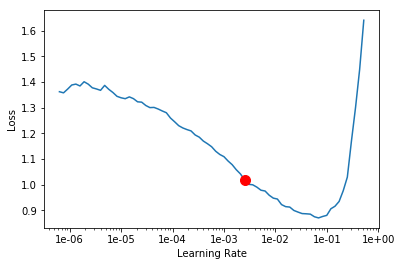

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(2, 1.0e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.848150,0.497085,0.821549,05:43
1,0.622651,0.400728,0.851852,05:40


In [0]:
learn.save("stage-1")

In [0]:
db = (ImageList.from_folder(path)
               .split_none()
               .label_from_folder()
               .transform(size = 224)
               .databunch())

In [0]:
learn = cnn_learner(db, models.resnet34, metrics = [accuracy])
learn.load("stage-1")

In [0]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [0]:
ImageCleaner(ds, idxs, path)

In [0]:
import pandas as pd
df = pd.read_csv(path/'cleaned_resnet34.csv', header='infer') # Read  csv produced by fastai ImageCleaner into data frame
df.head()

,name,label
0,Damaged/63.jpg,Damaged
1,Damaged/i DamagedWood _images45.jpg,Damaged
2,Damaged/1568318123553.jpeg,Damaged
3,Damaged/i DamagedWood _images92.jpg,Damaged
4,Damaged/images32.jpg,Damaged


In [0]:
bs = 64
data64 = ImageDataBunch.from_df(path,
                               df, 
                               valid_pct = 0.2,
                               ds_tfms = get_transforms(), 
                               size = 64, 
                               bs = bs, 
                               num_workers = 4).normalize(imagenet_stats)

data128 = ImageDataBunch.from_df(path, 
                                df, 
                                valid_pct = 0.2, 
                                ds_tfms = get_transforms(), 
                                size = 128, 
                                bs = bs, 
                                num_workers = 4).normalize(imagenet_stats)

data224 = ImageDataBunch.from_df(path, 
                                df, 
                                valid_pct = 0.2, 
                                ds_tfms = get_transforms(), 
                                size = 224, 
                                bs = bs, 
                                num_workers = 4).normalize(imagenet_stats)

# Exploratory Data Visualizations

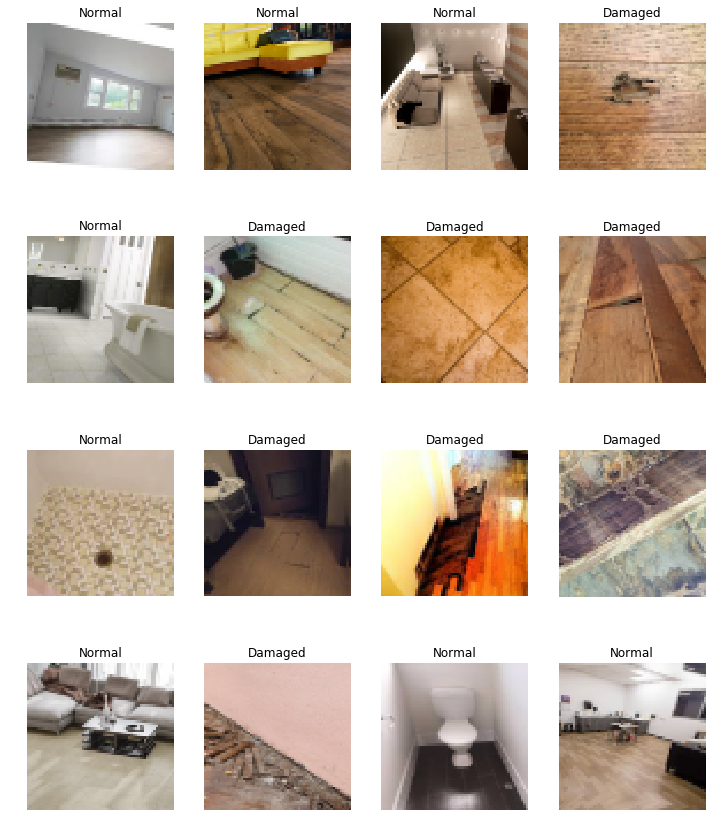

In [0]:
data64.show_batch(rows=4, figsize=(10,12))

In [0]:
data64.classes, data64.c, len(data64.train_ds), len(data64.valid_ds)

(['Damaged', 'Normal'], 2, 1188, 297)

[776, 709]


<function matplotlib.pyplot.show>

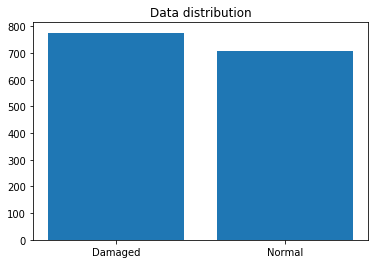

In [0]:
counts=[(data_whole.y.items==i).sum() for i in range(len(data64.classes))]
print(counts)
plt.bar(data64.classes,counts)
plt.title('Data distribution')
plt.show

[1188, 297]


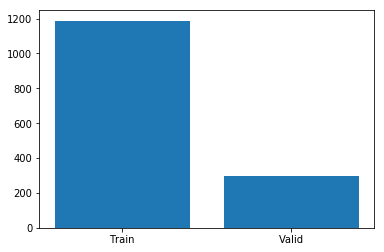

In [0]:
counts = [len(data64.train_ds), len(data64.valid_ds)]
print(counts)
plt.bar(["Train", "Valid"], counts)
plt.show()

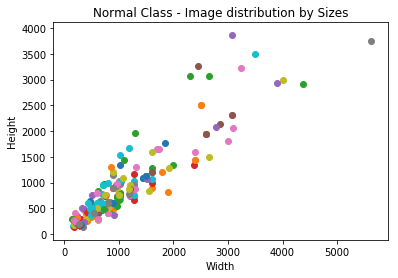

In [0]:
fnames = get_image_files(path/'Normal')

width_height=[]
for i in fnames:
    im = Image.open(i)
    width, height = im.size
    width_height.append((width, height))    
for i in width_height:    
    plt.scatter(i[0],i[1])
    plt.title('Normal Class - Image distribution by Sizes')
    plt.xlabel('Width')
    plt.ylabel('Height')

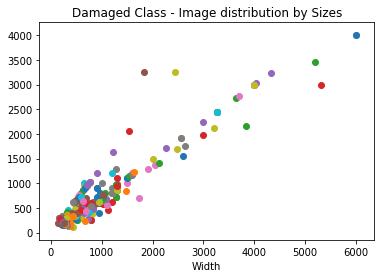

In [0]:
fnames = get_image_files(path/'Damaged')

width_height=[]
for i in fnames:
    im = Image.open(i)
    width, height = im.size
    width_height.append((width, height))
    
for i in width_height:    
    plt.scatter(i[0],i[1])
    plt.title('Damaged Class - Image distribution by Sizes')
    plt.xlabel('Width')

In [0]:
train = list(map(str, data64.train_dl.y))
valid = list(map(str, data64.valid_dl.y))

classList = [train, valid]
names = ["train", "valid"]

#plt.hist(classList, label = names, stacked = True)
#plt.legend()

width = 0.8
ind = (1, 2)
damage = (train.count("Damage"), valid.count("Damage"))
normal = (train.count("Normal"), valid.count("Normal"))

p1 = plt.bar(ind, damage, width)
p2 = plt.bar(ind, normal, width, bottom = damage)

plt.ylabel("Image Count")
plt.xticks(ind, ("damage", "normal"))
plt.legend((p1[0], p2[0]), ("Damage", "Normal"))

NameError: ignored

# Modeling

## **Data64**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.75E-03


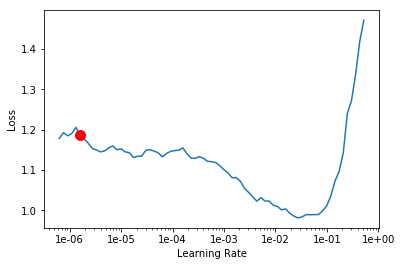

In [0]:
learn = cnn_learner(data64, models.resnet34, metrics=accuracy)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(4, 1.58e-6 )

epoch,train_loss,valid_loss,accuracy,time
0,1.074111,0.810194,0.582492,01:21
1,1.128549,0.796342,0.572391,01:21
2,1.120213,0.786884,0.569024,01:20
3,1.098714,0.787304,0.569024,01:21


In [0]:
learn.save("result-64-frozen")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 3.63E-04


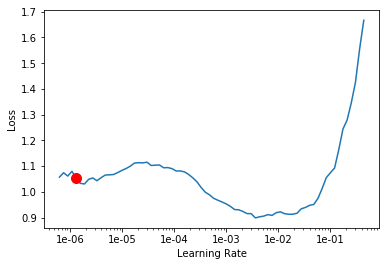

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(5, 1.32e-6)

epoch,train_loss,valid_loss,accuracy,time
0,1.080852,0.765908,0.595960,01:17
1,1.074667,0.770986,0.606061,01:16
2,1.092794,0.772239,0.592593,01:16
3,1.081113,0.764141,0.602694,01:16
4,1.103982,0.756651,0.599327,01:17


In [0]:
learn.save("result-64-unfrozen")

## **Data128**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 3.98E-03


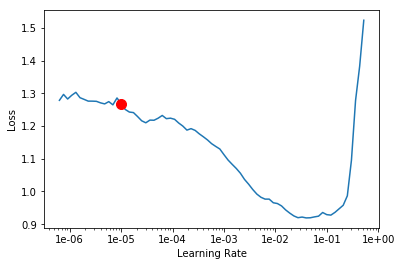

In [0]:
learn = cnn_learner(data128, models.resnet34, metrics=accuracy)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(4, 1.0e-5 )

epoch,train_loss,valid_loss,accuracy,time
0,1.188811,0.880390,0.575758,02:12
1,1.201467,0.816094,0.562290,02:11
2,1.211877,0.783807,0.585859,02:12
3,1.175286,0.770917,0.595960,02:11


In [0]:
learn.save("result-128-frozen")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 7.59E-04


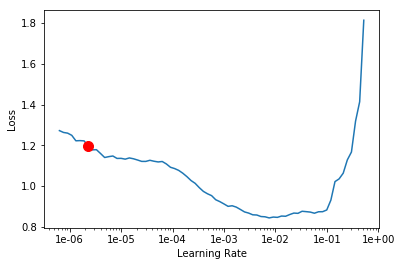

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(4, 2.29E-6)

epoch,train_loss,valid_loss,accuracy,time
0,1.130412,0.757255,0.606061,02:56
1,1.078233,0.705265,0.626263,02:55
2,1.090774,0.683050,0.653199,02:55
3,1.100726,0.668908,0.666667,02:54


In [0]:
learn.save("result-128-unfrozen")

## **Data224**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 8.32E-03


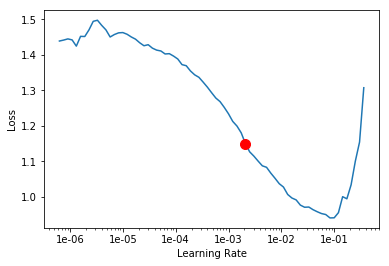

In [0]:
learn = cnn_learner(data224, models.resnet34, metrics=accuracy)
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(4, 2.09E-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.972429,0.482545,0.855219,05:44
1,0.670748,0.379792,0.895623,05:43
2,0.520973,0.395113,0.878788,05:44
3,0.422579,0.392377,0.875421,05:43


In [0]:
learn.save("result-224-frozen")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 7.59E-08


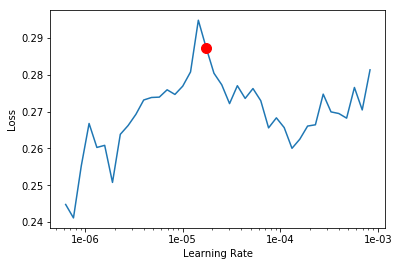

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.fit_one_cycle(4, 1.74e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.323615,0.386809,0.882155,07:36
1,0.264012,0.388945,0.888889,07:36
2,0.234429,0.388546,0.892256,07:35
3,0.225620,0.394379,0.885522,07:38


In [0]:
learn.save("result-224-unfrozen")

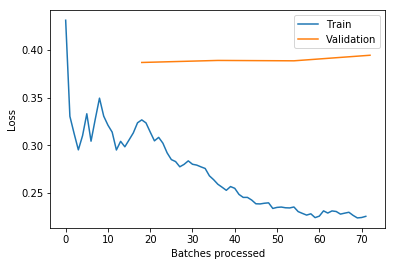

In [0]:
learn.recorder.plot_losses()

In [0]:
pred,label= learn.get_preds()
accuracy(pred, label)

tensor(0.8855)

## **Original Data**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 8.32E-03


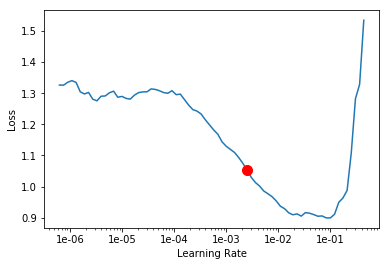

In [0]:
learn_ori = cnn_learner(data, models.resnet34, metrics=accuracy)
learn_ori.lr_find()
learn_ori.recorder.plot(suggestion = True)

In [0]:
learn_ori.fit_one_cycle(4, 2.5e-3 )

epoch,train_loss,valid_loss,accuracy,time
0,0.860677,0.557391,0.838384,05:45
1,0.604955,0.496001,0.858586,05:45
2,0.473352,0.445119,0.878788,05:45
3,0.372524,0.416135,0.878788,05:44


In [0]:
learn_ori.save("result-224-unfrozen_ori")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.75E-05


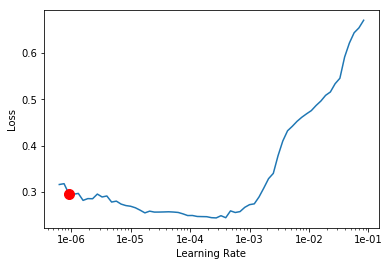

In [0]:
learn_ori.unfreeze()
learn_ori.lr_find()
learn_ori.recorder.plot(suggestion = True)

In [0]:
learn_ori.fit_one_cycle(6, max_lr = slice(1.1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.251861,0.409116,0.875421,07:36
1,0.225119,0.452539,0.865320,07:36
2,0.196339,0.448027,0.878788,07:36
3,0.174185,0.438147,0.882155,07:36
4,0.151262,0.456663,0.882155,07:37
5,0.135685,0.449504,0.878788,07:37


In [0]:
learn_ori.save("result-224-unfrozen_ori_unfrozen")

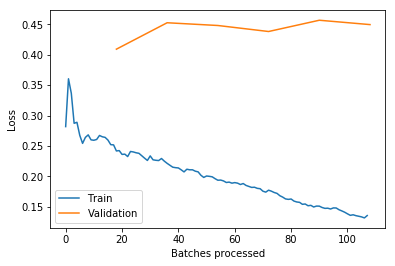

In [0]:
learn_ori.recorder.plot_losses()

In [0]:
pred,label= learn_ori.get_preds()
accuracy(pred, label)

tensor(0.8788)

# **Model Evaluation**

## **Data224**

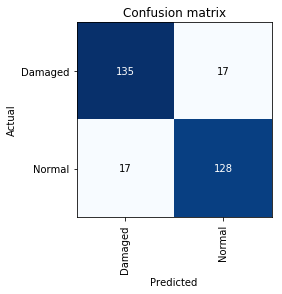

In [0]:
learn.load('result-224-unfrozen')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [0]:
interp.top_losses(k=9)

torch.return_types.topk(values=tensor([9.1365, 6.4857, 6.2828, 6.2179, 5.3765, 5.3639, 5.2811, 5.2237, 4.8742]), indices=tensor([156,  74, 174, 222,  65,  15, 112,  91,  82]))

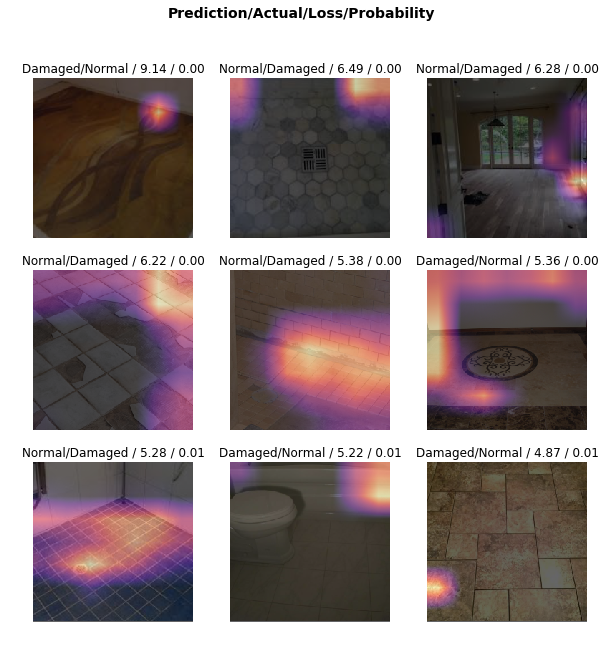

In [0]:
interp.plot_top_losses(9, figsize=(10, 10), heatmap=True)

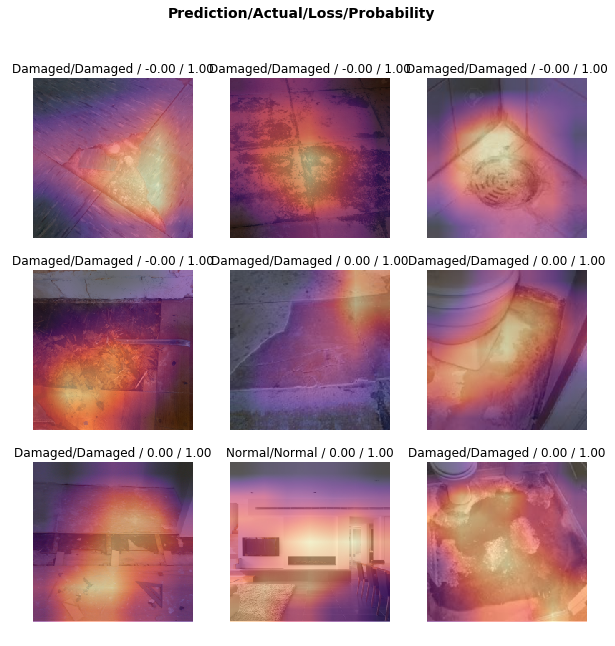

In [0]:
interp.plot_top_losses(9, figsize=(10, 10),largest = False, heatmap = True)

## **Original Data**

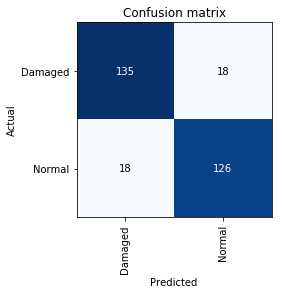

In [0]:
learn_ori.load('result-224-unfrozen_ori_unfrozen')
interp = ClassificationInterpretation.from_learner(learn_ori)
interp.plot_confusion_matrix()

In [0]:
interp.top_losses(k=9)

torch.return_types.topk(values=tensor([12.8478,  9.3338,  8.8816,  7.1829,  6.5273,  6.3910,  6.0455,  5.9551,
         5.1559]), indices=tensor([173, 210, 120, 171, 109,  80,  19, 252, 168]))

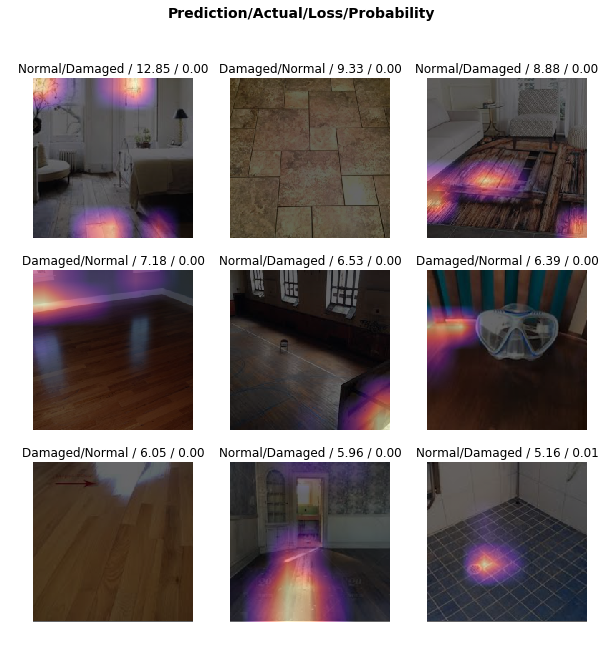

In [0]:
interp.plot_top_losses(9, figsize=(10, 10), heatmap=True)

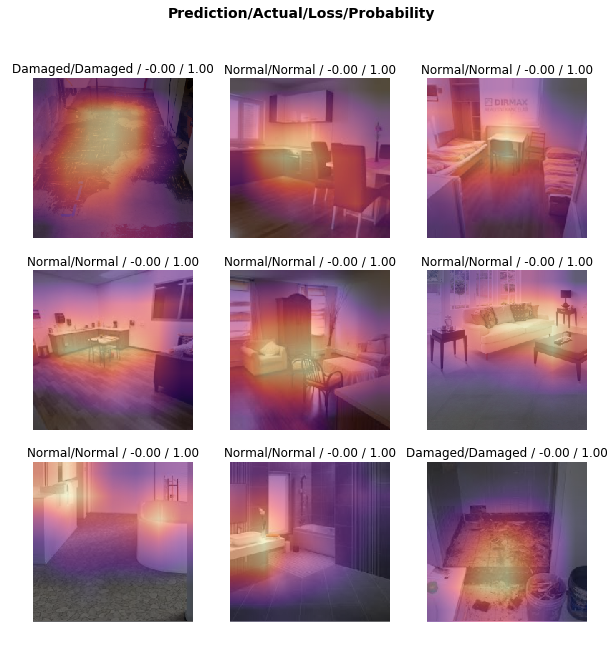

In [0]:
interp.plot_top_losses(9, figsize=(10, 10),largest = False, heatmap = True)

In [0]:
interp.most_confused(min_val=2)

[('Damaged', 'Normal', 18), ('Normal', 'Damaged', 18)]

# **Try Mixup**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 6.92E-03


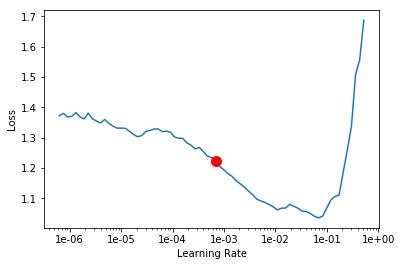

In [0]:
learn_mixup = cnn_learner(data224, models.resnet34, metrics = error_rate).mixup()
learn_mixup.lr_find()
learn_mixup.recorder.plot(suggestion = True)

In [0]:
learn_mixup.fit_one_cycle(4, 6.0e-4 )

NameError: ignored

In [0]:
learn_mixup.save("result-224-unfrozen_ori_mixup")